In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from sapy.components import Clock, ProgramCounter, MemoryAddressRegister, \
    RandomAccessMemory, SwitchBoard, RegisterA, RegisterB, \
    RegisterOutput, ArithmeticUnit, RegisterInstruction, Computer, opcode_map
from sapy.assembler import assemble

# Hex and Binary Literals in Python

In [4]:
0xF

15

In [5]:
0xFF

255

In [6]:
print(15_000) # underscore as separators are allowed
print(0b1111_1111)

15000
255


You can also format integers to HEX using X

In [7]:
f"0x{232:02X}"

'0xE8'

# Assembly Language

In [8]:
assemble("LDA #$07")

0x00	20 07	 # LDA #$07


[32, 7]

# Clocking Signals

In [9]:
clk = Clock()
class DummyComponent():
    def data(self, con=tuple()):
        print("data accessed")
        return 42
    def clock(self, data, con=tuple()):
        print("clock stepped")

dc = DummyComponent()
clk.add_component(dc)

In [10]:
print("step 1: ---------")
clk.step()
print("step 2: ---------")
clk.step()

step 1: ---------
data accessed
------------------------------------------
PCADDRESS: $2A
T0: Data: $2A, Control Word: ('ep', 'lm', 'cp')
clock stepped
step 2: ---------
data accessed
T1: Data: $2A, Control Word: ('er', 'li')
clock stepped


# Program Counter

To enable a component to take an action on a clock, you pass in the correct control bit as a keyword argument. To enable the PC to output to the data but, use the "ep" control bit.

In [11]:
pc = ProgramCounter()

In [12]:
pc.clock()
pc.data()

In [13]:
pc.clock()
pc.data(con=['ep'])

0

In [16]:
pc.clock()
pc.data(con=['ep'])

0

To increment the program counter, the control bit is "cp".

In [17]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

1

In [18]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

2

In [19]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

3

For jump instructions you set the program counter directly. This is done with the "lp" control bit.

In [ ]:
pc.clock(data=0xD, con=['lp'])
print(f"0x{pc.data(con=['ep']):02X}")
print(f"{pc.data(con=['ep'])}")

# Accumulator (Register A)

In [20]:
reg_a = RegisterA()
print(f"The register value on reset is: 0x{reg_a.data(con=['ea']):0X}")

reg_a.clock(data=0xAB, con=['la'])
reg_a.data(con=['ea'])
print(f"The register has latched a value: 0x{reg_a.data(con=['ea']):0X}")


The register value on reset is: 0x0
The register has latched a value: 0xAB


# ALU
## Arithmatic Logic Unit

Some components have extra attributes that allow it to communicate directly to other components outside of the bus. 

The ALU is not clocked, it doesn't even have state. The data output from the ALU is alway the instantaneous sum (or difference) of Reg A + Reg B

In [21]:
reg_a = RegisterA()
reg_a.clock(data=4, con=['la'])

reg_b = RegisterB()
reg_b.clock(data=3, con=['lb'])

alu = ArithmeticUnit(reg_a, reg_b)

alu.data(con=['eu'])

print(f"\t0x{reg_a.value:02X}")
print(f"+\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu']):02X}")

	0x04
+	0x03
------------
	0x07


In [23]:
# change the value of the register feeding the alu
reg_b.clock(data=1, con=['lb'])
alu.data(con=['eu'])

print(f"\t0x{reg_a.value:02X}")
print(f"+\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu']):02X}")

	0x04
+	0x01
------------
	0x05


Subtraction

In [24]:

print(f"\t0x{reg_a.value:02X}")
print(f"-\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu', 'su']):02X}")

	0x04
-	0x01
------------
	0x03


# Memory

Ram is another example of a system that has communication outside the bus, it always access the RAM value stored at the address latched in the Memory Address Register.

In [25]:
mar = MemoryAddressRegister()
ram = RandomAccessMemory(mar)

# store address for ram in register
mar.clock(data=0x0F, con=['lm'])
print(f"Memory Address: 0x{mar.value:02X}")


# clock data into ram at the address set above
ram.clock(data=0xAB, con=['lr'])
assert ram.data() == None
print(f"Memory at address: 0x{mar.value:02X} is 0x{ram.data(con=['er']):02X}") # should be 0xAB
print(f"Memory at address: {mar.value} is {ram.data(con=['er'])}") # just to demystify hex..

Memory Address: 0x0F
Memory at address: 0x0F is 0xAB
Memory at address: 15 is 171


# Controller: Sequencer + Decoder + Clock

In [26]:
reg_i = RegisterInstruction()
instruction = 0xFF # both opcode and argument, 8bits
reg_i.clock(data=instruction, con=['li'])


In [27]:
print(f"The opcode is {reg_i.value:X}")

The opcode is FF


# Example Sequencing: LDA

In [28]:
from sapy.components import Computer

cpu = Computer()
rom = [
    0x00, 0x09, # 0x0 LDA 09H
    ]
cpu.switches.load_program(rom)

for _ in range(7):
    cpu.step(debug=True) 

------------------------------------------
PCADDRESS: $00
T0: Data: $00, Control Word: ('ep', 'lm', 'cp')
T1: Data: $00, Control Word: ('er', 'li')
OPCODE: $00, MNE: LDA
T2: Data: $01, Control Word: ('ep', 'lm', 'cp')
T3: Data: $09, Control Word: ('er', 'lm')
T4: Data: $00, Control Word: ('er', 'la')
------------------------------------------
PCADDRESS: $02
T0: Data: $02, Control Word: ('ep', 'lm', 'cp')
T1: Data: $00, Control Word: ('er', 'li')
OPCODE: $00, MNE: LDA


In [ ]:
cpu.step(debug=True)

# Output (Register O)

In [29]:
reg_o = RegisterOutput()
reg_o.clock(data=0x90, con=['lo'])

Output Display: 90


In [30]:
# monkey patch output function for fancy display
def display_number(x):
    print(f"***### {x} ###***")
reg_o.output_function = display_number

In [31]:
reg_o.clock(data=0x90, con=['lo'])

***### 144 ###***


# Full Computer with ROM

In [32]:
cpu = Computer()
rom = [
    0x00, 0x07, # 0x00 LDA 07H
    0x01, 0x08, # 0x02 ADD 08H
    0xF6,       # 0x04 OTA
    0x34, 0x02, # 0x05 JMP 02H
    0x00,       # 0x07 A1H
    0x03,       # 0x08 22H
    ]
cpu.switches.load_program(rom)

In [33]:
for _ in range(5):
    cpu.step(instructionwise=True)

------------------------------------------
PCADDRESS: $00
T0: Data: $00, Control Word: ('ep', 'lm', 'cp')
T1: Data: $00, Control Word: ('er', 'li')
OPCODE: $00, MNE: LDA
T2: Data: $01, Control Word: ('ep', 'lm', 'cp')
T3: Data: $07, Control Word: ('er', 'lm')
T4: Data: $00, Control Word: ('er', 'la')
------------------------------------------
PCADDRESS: $02
T0: Data: $02, Control Word: ('ep', 'lm', 'cp')
T1: Data: $01, Control Word: ('er', 'li')
OPCODE: $01, MNE: ADD
T2: Data: $03, Control Word: ('ep', 'lm', 'cp')
T3: Data: $08, Control Word: ('er', 'lm')
T4: Data: $03, Control Word: ('er', 'lb')
T5: Data: $03, Control Word: ('eu', 'la')
------------------------------------------
PCADDRESS: $04
T0: Data: $04, Control Word: ('ep', 'lm', 'cp')
T1: Data: $F6, Control Word: ('er', 'li')
OPCODE: $F6, MNE: OTA
T2: Data: $03, Control Word: ('ea', 'lo')
Output Display: 3
------------------------------------------
PCADDRESS: $05
T0: Data: $05, Control Word: ('ep', 'lm', 'cp')
T1: Data: $34, Con

In [ ]:
for _ in range(3):
    cpu.step(instructionwise=True, debug=True)

In [34]:
import ipywidgets as widgets
from IPython.display import display
gui_output_display = widgets.FloatText()
display(gui_output_display)

# monkey patch output function
def display_number(x):
    gui_output_display.value = x

cpu.reg_o.output_function = display_number

FloatText(value=0.0)

In [35]:
for _ in range(3):
    time.sleep(.2)
    cpu.step(instructionwise=True, debug=False)

In [36]:
for _ in range(27):
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

In [37]:
while True:
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

KeyboardInterrupt: 

# DMA

In [38]:
%matplotlib notebook

In [39]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
def setup_matplot_gui(cpu):
    plt.ion()
    fig, ax = plt.subplots(1,1)
    initial_bitmap = np.zeros((0xF + 1, 0xF + 1))
    initial_bitmap[0,0] = 0xFF # get the color map set
    heatmap = ax.imshow(initial_bitmap)
    plt.show()
    initial_bitmap[0,0] = 0x00 # reset bitmap
    heatmap.set_data(initial_bitmap)
    fig.canvas.draw()

    def plt_memory(bitmap):
        heatmap.set_data(bitmap)
        fig.canvas.draw()
    cpu.dma.connect_dma_handler(plt_memory)

In [40]:
cpu = Computer()

In [41]:
countup = """
    LDA #$99
    ADD #$0E
    DMA
    STA  $4A
    JMP  $02
    """

countup_bytes = assemble(countup)

0x00	20 99	 # LDA #$99
0x02	21 0E	 # ADD #$0E
0x04	FD   	 # DMA
0x05	35 4A	 # STA  $4A
0x07	34 02	 # JMP  $02


In [46]:
moveacross = """
    LDA #$10
    loop:
    ADD #$03
    DMA
    STA  $0B
    STA ($0B)
    JMP  loop
    """

moveacross_bytes = assemble(moveacross)

0x00	20 10	 # LDA #$10
0x02	21 03	 # ADD #$03
0x04	FD   	 # DMA
0x05	35 0B	 # STA  $0B
0x07	45 0B	 # STA ($0B)
0x09	34 02	 # JMP  $02


<IPython.core.display.Javascript object>


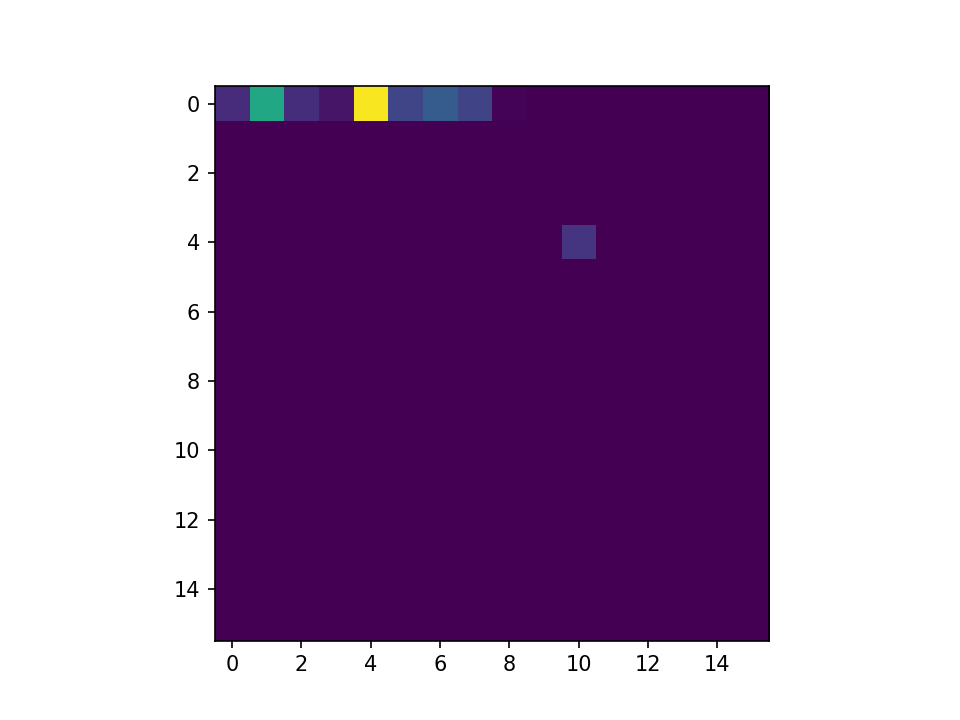

50
100
150
200
250


In [45]:
cpu.reset()
cpu.switches.load_program(countup_bytes)
setup_matplot_gui(cpu)

n = 0
for i in range(263):
    n += 1
    if n % 50 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

<IPython.core.display.Javascript object>


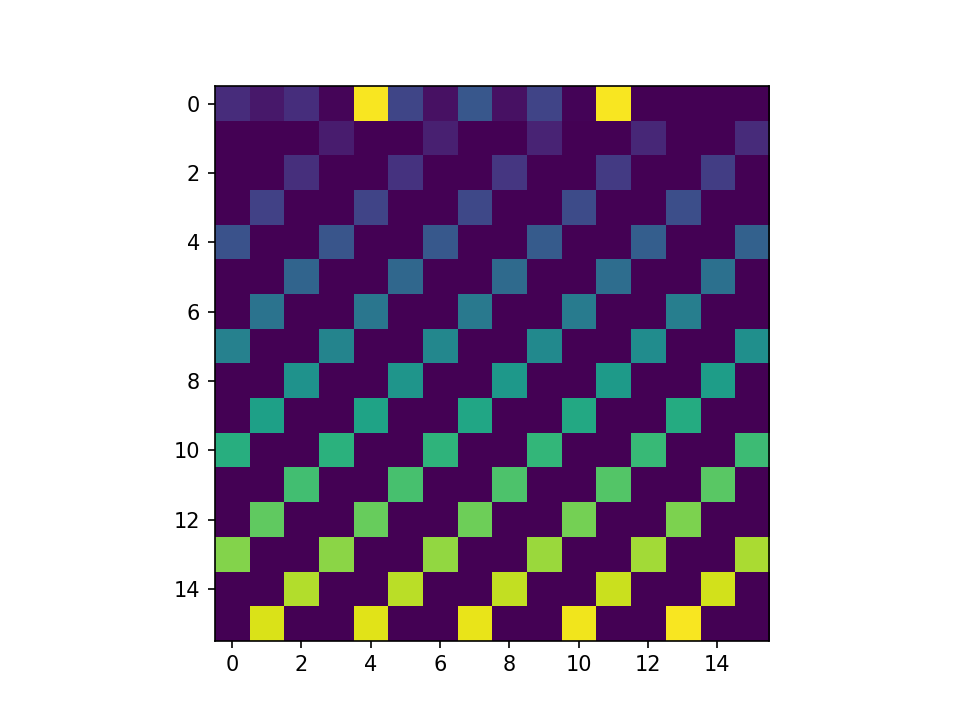

50
100
150
200
250
300
350
400


In [47]:
cpu.reset()
cpu.switches.load_program(moveacross_bytes)
setup_matplot_gui(cpu)

n = 0
for i in range(400):
    n += 1
    if n % 50 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

In [48]:
# speed test
cpu.switches.load_program(countup_bytes)
cpu.reset()
cpu.dma.connect_dma_handler(None)
n = 0

for i in range(50000):
    n += 1
    if n % 5000 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [ ]:
plt.show()

In [ ]:
while True:
    time.sleep(0.001)
    n += 1
    if n % 100 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
#var name test
LDA

In [ ]:
0xF3 >> 4